In [2]:
# Needed only on Google Colab
try:
    import google.colab
    !pip install aiohttp requests zarr
    print('\n------------- Packages on Google Colab are installed ------------')
except:
    print('\n------------- Not running on Google Colab --------------')


------------- Not running on Google Colab --------------


In [3]:
import fsspec
import xarray as xr
import matplotlib.pyplot as plt

# Data is located on [Greene](https://sites.google.com/nyu.edu/nyu-hpc/hpc-systems/greene) cluster (NYU) and shared with [Globus](https://sites.google.com/nyu.edu/nyu-hpc/hpc-systems/hpc-storage/data-management/data-transfers/globus).
* Structure of the folders is the following:
```
├── eddy
│   ├── 48
│   │   ├── gauss
│   │   ├── hires-gauss
│   │   ├── hires-sharp
│   │   ├── lores
│   │   └── sharp
│   ├── 64
│   │   ├── gauss
│   │   ├── hires-gauss
│   │   ├── hires-sharp
│   │   ├── lores
│   │   └── sharp
│   ├── 96
│   │   ├── gauss
│   │   ├── hires-gauss
│   │   ├── hires-sharp
│   │   ├── lores
│   │   └── sharp
│   └── hires
├── jet
│   ├── 48
│   │   ├── gauss
│   │   ├── hires-gauss
│   │   ├── hires-sharp
│   │   ├── lores
│   │   └── sharp
│   ├── 64
│   │   ├── gauss
│   │   ├── hires-gauss
│   │   ├── hires-sharp
│   │   ├── lores
│   │   └── sharp
│   ├── 96
│   │   ├── gauss
│   │   ├── hires-gauss
│   │   ├── hires-sharp
│   │   ├── lores
│   │   └── sharp
│   └── hires
```
* Every individual dataset is a `.zarr` [archive](https://zarr.readthedocs.io/en/stable/)
* `eddy/jet` - configuration of the pyqg; eddy is default; See [Ross2022](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022MS003258) for description
* `hires.zarr` - high-resolution simulation at 256x256 grid
* `48/64/96` - resolution of the coarse models
* `lores.zarr` - low-resolution simulation
* `gauss.zarr`, `sharp.zarr` - training datasets for prediction of subgrid forcing obtained with Gaussian or Sharp filters
* `hires-gauss.zarr`, `hires-sharp.zarr` - high-resolution simulation projected onto coarse grid with Gaussian or Sharp filters

In [5]:
def open_zarr(folder):
    for url, label in zip(['https://g-402b19.00888.8540.data.globus.org', 'https://g-771f59.00888.8540.data.globus.org'], ['archive', 'scratch']):
      try:
        mapper = fsspec.get_mapper(f'{url}/{folder}.zarr')
        return xr.open_zarr(mapper, consolidated=True)
      except:
        print(f'{folder} on {label} failed')

# Hires, lores and projected hires simulations

In [6]:
hires = open_zarr('eddy/hires')
lores = open_zarr('eddy/64/lores')
hires_sharp = open_zarr('eddy/64/hires-sharp')

### Data dimensions:
* `lev` - two fluid layers
* `time` - 172 time snapshots (20 years)
* `run` - 10 simulation
### Data variables:
* `q` - Potential vorticity
* `psi` - Streamfunction
* `u,v` - Horizontal velocity

In [7]:
hires_sharp

<xarray.Dataset>
Dimensions:         (run: 10, l: 64, k: 33, lev: 2, time: 172, y: 64, x: 64)
Coordinates:
  * k               (k) float64 0.0 6.283e-06 1.257e-05 ... 0.0001948 0.0002011
  * l               (l) float64 0.0 6.283e-06 ... -1.257e-05 -6.283e-06
  * lev             (lev) int32 1 2
  * run             (run) int64 0 1 2 3 4 5 6 7 8 9
  * time            (time) timedelta64[ns] 41 days 16:00:00.000028800 ... 716...
  * x               (x) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * y               (y) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
Data variables:
    APEflux         (run, l, k) float64 dask.array<chunksize=(10, 64, 33), meta=np.ndarray>
    APEgenspec      (run, l, k) float64 dask.array<chunksize=(10, 64, 33), meta=np.ndarray>
    KEflux          (run, l, k) float64 dask.array<chunksize=(10, 64, 33), meta=np.ndarray>
    KEfrictionspec  (run, l, k) float64 dask.array<chunksize=(10, 64, 33), meta=np.ndarray>
    KEspec          (run, lev, l, k) float64 dask.array<chunksize=(10, 2, 64, 33), meta=np.ndarray>
    psi             (run, time, lev, y, x) float64 dask.array<chunksize=(10, 172, 2, 64, 64), meta=np.ndarray>
    q               (run, time, lev, y, x) float64 dask.array<chunksize=(10, 172, 2, 64, 64), meta=np.ndarray>
    u               (run, time, lev, y, x) float64 dask.array<chunksize=(10, 172, 2, 64, 64), meta=np.ndarray>
    v               (run, time, lev, y, x) float64 dask.array<chunksize=(10, 172, 2, 64, 64), meta=np.ndarray>

In [8]:
idx = dict(run=0,time=-1,lev=0)

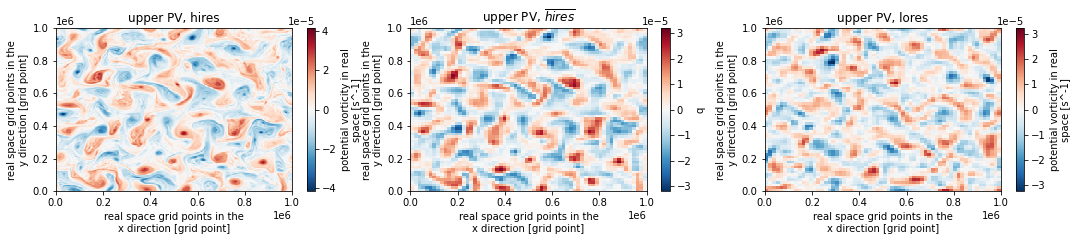

In [9]:
plt.figure(figsize=(18,3))
title = ['upper PV, hires', 'upper PV, $\overline{hires}$', 'upper PV, lores']
for j, ds in enumerate([hires, hires_sharp, lores]):
    plt.subplot(1,3,j+1)
    ds.q.isel(idx).plot()
    plt.title(title[j])

# Training dataset

In [10]:
train = open_zarr('eddy/64/sharp')

### Data dimensions:
* `lev` - two fluid layers
* `time` - 86 time snapshots (10 years)
* `run` - 300 simulation
### Data variables:
* `q_forcing_advection` - subgrid forcing $S = \nabla \cdot (\overline{\mathbf{u}} ~ \overline{q} - \overline{\mathbf{u} q})$
* `q` - Coarse-grained Potential vorticity $\overline{q}$

In [11]:
train

,Array,Chunk
Bytes,806.25 MiB,2.69 MiB
Shape,"(300, 86, 2, 64, 64)","(1, 86, 2, 64, 64)"
Count,301 Tasks,300 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,806.25 MiB,2.69 MiB
Shape,"(300, 86, 2, 64, 64)","(1, 86, 2, 64, 64)"
Count,301 Tasks,300 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


Text(0.5, 1.0, 'Lower subgrid forcing, $S_2$')

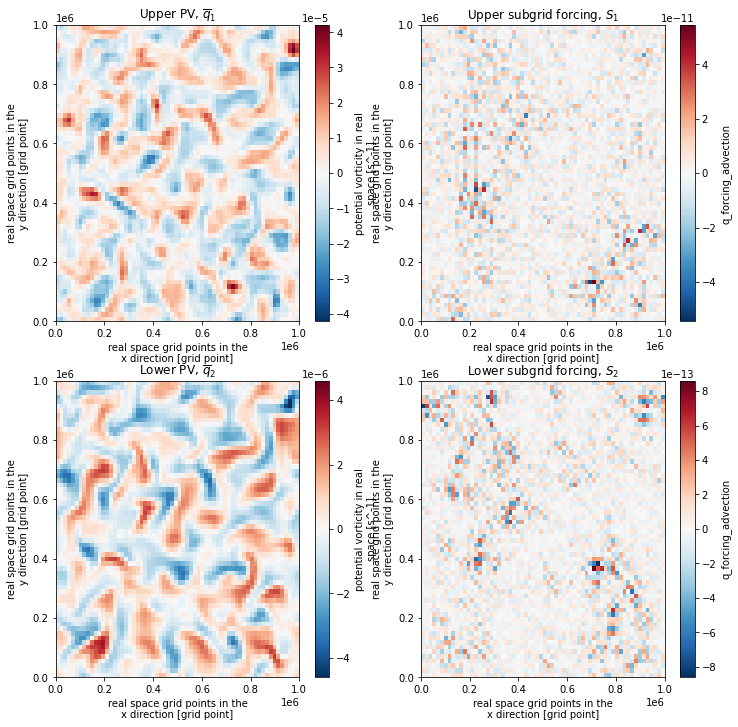

In [12]:
plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
train.q.isel(run=0,time=-1, lev=0).plot()
plt.title('Upper PV, $\overline{q}_1$')

plt.subplot(2,2,3)
train.q.isel(run=0,time=-1, lev=1).plot()
plt.title('Lower PV, $\overline{q}_2$')

plt.subplot(2,2,2)
train.q_forcing_advection.isel(run=0,time=-1, lev=0).plot()
plt.title('Upper subgrid forcing, $S_1$')

plt.subplot(2,2,4)
train.q_forcing_advection.isel(run=0,time=-1, lev=1).plot()
plt.title('Lower subgrid forcing, $S_2$')

In [ ]:
# Checksum
# Reference values:
# 5.701264812550037e-06
# 4.999136229013792e-12
print(train.q.load().astype('float64').std().values)
print(train.q_forcing_advection.load().astype('float64').std().values)

: 

: 